### Example Point Output and Averages of Portland and Scappoose over the years

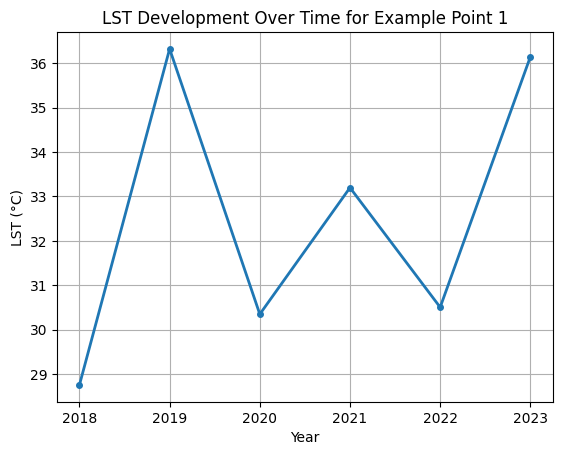

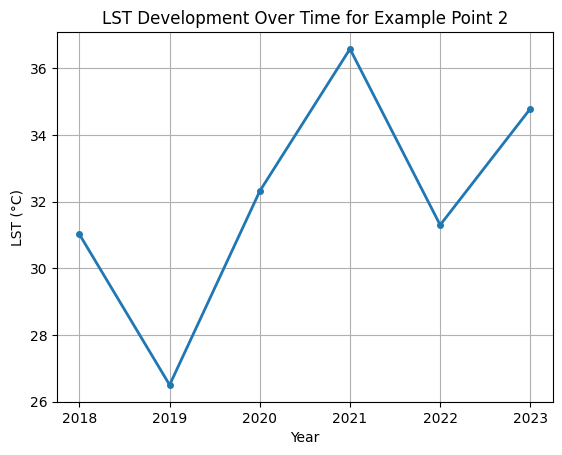

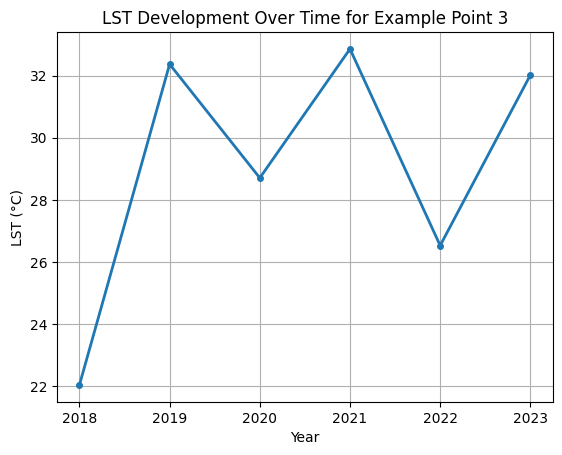

Year: 2018
Average LST for Portland in 2018 : 23.015259866682992
Average LST for Scappoose in 2018 : 21.16178060502277
Year: 2019
Average LST for Portland in 2019 : 24.087193729283456
Average LST for Scappoose in 2019 : 19.011342877527944
Year: 2020
Average LST for Portland in 2020 : 21.341494285625814
Average LST for Scappoose in 2020 : 18.25277692382604
Year: 2021
Average LST for Portland in 2021 : 27.98106957070979
Average LST for Scappoose in 2021 : 20.55116773800351
Year: 2022
Average LST for Portland in 2022 : 24.59234750415318
Average LST for Scappoose in 2022 : 17.055337706864847
Year: 2023
Average LST for Portland in 2023 : 28.3588564556658
Average LST for Scappoose in 2023 : 22.44127756990461


In [6]:
import ee
import matplotlib.pyplot as plt
import numpy as np

# Authenticate and initialize Earth Engine
ee.Authenticate()
# Here you need to add the name of your own project in "Google Earth Engin"
ee.Initialize(project='eo4c-nicosherpa')

# Define the coordinates for Portland, Oregon
portland = ee.Geometry.Point([-122.6784, 45.5152])

# Define bounding boxes around Portland and Scappoose
portlandBBox = ee.Geometry.Rectangle([-123.0, 45.3, -122.3, 45.7])
scappooseBBox = ee.Geometry.Rectangle([-123.1, 45.7, -122.7, 45.9])

# Function to Mask Clouds and Cloud Shadows in Landsat 8 Imagery
def cloudMask(image):
    cloudShadowBitmask = (1 << 3)
    cloudBitmask = (1 << 5)
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitmask).eq(0).And(qa.bitwiseAnd(cloudBitmask).eq(0))
    return image.updateMask(mask)

# Function to apply scaling factors for Landsat 8 imagery
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

# Import and preprocess Landsat 8 imagery
landsat8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").map(applyScaleFactors).map(cloudMask)

# Function to calculate the average LST for a given period
def calculateAverageLST(startDate, endDate, area):
    period = landsat8.filterBounds(area).filterDate(startDate, endDate).median().clip(area)
    lst = period.select('ST_B10').subtract(273.15).rename('LST')
    return lst

# Define the list of years to analyze
years = list(range(2018, 2024))

# Function to create a chart for a pixel
def createChart(pixel, index):
    pixelValues = []
    for year in years:
        startDate = ee.Date.fromYMD(year, 1, 1)
        endDate = ee.Date.fromYMD(year, 12, 31)
        pixelLST = calculateAverageLST(startDate.format('YYYY-MM-dd').getInfo(), endDate.format('YYYY-MM-dd').getInfo(), pixel)
        value = pixelLST.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=pixel,
            scale=30,
            maxPixels=1e9
        ).get('LST').getInfo()
        pixelValues.append([year, value])
    
    years_list = [pv[0] for pv in pixelValues]
    lst_list = [pv[1] for pv in pixelValues]
    
    plt.figure()
    plt.plot(years_list, lst_list, marker='o', linestyle='-', linewidth=2, markersize=4)
    plt.title(f'LST Development Over Time for Example Point {index}')
    plt.xlabel('Year')
    plt.ylabel('LST (°C)')
    plt.grid(True)
    plt.show()

# Define example points within the Portland bounding box
examplePoints = [
    ee.Geometry.Point([-122.8057583, 45.486836]),  # Example Point 1
    ee.Geometry.Point([-122.6589563, 45.5214872]),  # Example Point 2
    ee.Geometry.Point([-122.5846527, 45.5555345])   # Example Point 3
]

# Create charts for each example point
for index, point in enumerate(examplePoints):
    createChart(point, index + 1)

# Calculate and display LST changes and print average LST for Portland and Scappoose
for year in years:
    startDate = ee.Date.fromYMD(year, 1, 1)
    endDate = ee.Date.fromYMD(year, 12, 31)

    # Calculate average LST for Scappoose
    scappooseLST = calculateAverageLST(startDate.format('YYYY-MM-dd').getInfo(), endDate.format('YYYY-MM-dd').getInfo(), scappooseBBox)
    scappooseMeanLST = scappooseLST.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=scappooseBBox,
        scale=30,
        maxPixels=1e9
    ).get('LST').getInfo()

    # Calculate average LST for Portland
    portlandLST = calculateAverageLST(startDate.format('YYYY-MM-dd').getInfo(), endDate.format('YYYY-MM-dd').getInfo(), portlandBBox)
    portlandMeanLST = portlandLST.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=portlandBBox,
        scale=30,
        maxPixels=1e9
    ).get('LST').getInfo()

    # Print the average LST for both Portland and Scappoose for each year
    print('Year:', year)
    print('Average LST for Portland in', year, ':', portlandMeanLST)
    print('Average LST for Scappoose in', year, ':', scappooseMeanLST)

    # Calculate deviations from the Scappoose mean
    deviation = portlandLST.subtract(scappooseMeanLST)

    # Visualization parameters for deviations
    visParams = {
        'min': -20,
        'max': 20,
        'palette': [
            '0000FF', '5050FF', 'A0A0FF', 'FFFFFF', 'FFA0A0', 'FF5050', 'FF0000'
        ]
    }

    # Add the deviation layer to the map
    # Note: The map display part in Python is different and typically requires a different library (e.g., folium)
    # For the sake of completeness, here is how it would look
    # Add the legend after adding all layers

# Note: Adding the legend to a map in Python would require a visualization library like folium or matplotlib.


### Map output

In [7]:
import ee
import folium

# Initialize the Earth Engine module.
ee.Initialize()

# Define the coordinates for Portland, Oregon
portland = ee.Geometry.Point([-122.6784, 45.5152])

# Define bounding boxes around Portland and Scappoose
portlandBBox = ee.Geometry.Rectangle([-123.0, 45.3, -122.3, 45.7])
scappooseBBox = ee.Geometry.Rectangle([-123.1, 45.7, -122.7, 45.9])

# Function to Mask Clouds and Cloud Shadows in Landsat 8 Imagery
def cloudMask(image):
    cloudShadowBitmask = (1 << 3)
    cloudBitmask = (1 << 5)
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitmask).eq(0).And(qa.bitwiseAnd(cloudBitmask).eq(0))
    return image.updateMask(mask)

# Function to apply scaling factors for Landsat 8 imagery
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

# Import and preprocess Landsat 8 imagery
landsat8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").map(applyScaleFactors).map(cloudMask)

# Function to calculate the average LST for a given period
def calculateAverageLST(startDate, endDate, area):
    period = landsat8.filterBounds(area).filterDate(startDate, endDate).median().clip(area)
    lst = period.select('ST_B10').subtract(273.15).rename('LST')
    return lst

# Define the list of years to analyze
years = list(range(2018, 2024))

# Create a folium map centered on Portland
map_center = [45.5152, -122.6784]
m = folium.Map(location=map_center, zoom_start=10)

# Function to add Earth Engine layer to the folium map
def add_ee_layer(map_object, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data © <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(map_object)

# Loop through each year to calculate and display LST changes
for year in years:
    startDate = ee.Date.fromYMD(year, 1, 1)
    endDate = ee.Date.fromYMD(year, 12, 31)

    # Calculate average LST for Scappoose
    scappooseLST = calculateAverageLST(startDate.format('YYYY-MM-dd').getInfo(), endDate.format('YYYY-MM-dd').getInfo(), scappooseBBox)
    scappooseMeanLST = scappooseLST.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=scappooseBBox,
        scale=30,
        maxPixels=1e9
    ).get('LST').getInfo()

    # Calculate average LST for Portland
    portlandLST = calculateAverageLST(startDate.format('YYYY-MM-dd').getInfo(), endDate.format('YYYY-MM-dd').getInfo(), portlandBBox)
    portlandMeanLST = portlandLST.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=portlandBBox,
        scale=30,
        maxPixels=1e9
    ).get('LST').getInfo()

    # Calculate deviations from the Scappoose mean
    deviation = portlandLST.subtract(scappooseMeanLST)

    # Visualization parameters for deviations
    visParams = {
        'min': -20,
        'max': 20,
        'palette': [
            '0000FF', '5050FF', 'A0A0FF', 'FFFFFF', 'FFA0A0', 'FF5050', 'FF0000'
        ]
    }

    # Add the deviation layer to the map
    add_ee_layer(m, deviation, visParams, 'LST Deviation ' + str(year))

# Add layer control to the map
folium.LayerControl().add_to(m)

# Save the map as an HTML file
m.save('LST_Deviation_Map.html')
